In [1]:
import sys
sys.path.append("/home3/p306982/Simulations/fscil/algorithms_benchmarks/")
import os

import torch
import torch.nn.functional as F
import numpy as np
import copy
from tqdm import tqdm

from torch.utils.data import DataLoader, ConcatDataset
import torchaudio.transforms as T

# from torch_mate.data.utils import IncrementalFewShot

from neurobench.datasets import MSWC
from neurobench.datasets.MSWC_IncrementalLoader import IncrementalFewShot
from neurobench.examples.mswc_fscil.M5 import M5
from neurobench.models import TorchModel

from neurobench.examples.model_data.sparchSNNs import SNN
from neurobench.examples.model_data.sparchSNNs import RadLIFLayer

from neurobench.benchmarks import Benchmark
from neurobench.preprocessing import MFCCProcessor
from neurobench.preprocessing import S2SProcessor

from cl_utils import *


import argparse

In [67]:
ROOT = "//scratch/p306982/data/fscil/FSCIL_subset/" #"data/MSWC/"
NUM_WORKERS = 8
BATCH_SIZE = 256
NUM_REPEATS = 1
SPIKING = True
PRE_TRAIN = False

In [68]:
if SPIKING:
    EVAL_LR = 0.05
else:
    EVAL_LR = 0.3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    PIN_MEMORY = True
else:
    PIN_MEMORY = False

# Define MFCC pre-processing 
n_fft = 512
win_length = None
hop_length = 240
n_mels = 20
n_mfcc = 20

if SPIKING:
    encode = S2SProcessor(device, transpose=False)
    config_change = {"sample_rate": 48000,
                     "hop_length": 240}
    encode.configure(threshold=1.0, **config_change)
else:
    encode = MFCCProcessor(
        sample_rate=48000,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
            "f_min": 20,
            "f_max": 4000,
        },
        device = device
    )



squeeze = lambda x: (x[0].squeeze(), x[1])
out2pred = lambda x: torch.argmax(x, dim=-1)
to_device = lambda x: (x[0].to(device), x[1].to(device))

In [69]:
PT_MODEL = "SPmodel_shorttrain"

In [70]:
if SPIKING:
    model = torch.load("/home3/p306982/Simulations/fscil/algorithms_benchmarks/neurobench/examples/mswc_fscil/model_data/"+PT_MODEL, map_location=device)
    model = TorchModel(model)
    model.add_activation_module(RadLIFLayer)
else:
    model = M5(n_input=20, stride=2, n_channel=256, 
            n_output=200, input_kernel=4, pool_kernel=2, drop=True).to(device)
    load_dict = torch.load("/home3/p306982/Simulations/fscil/algorithms_benchmarks/neurobench/examples/mswc_fscil/model_data/mswc_mfcc_cnn", 
                        map_location=device).state_dict()
    model.load_state_dict(load_dict)
    model = TorchModel(model)

In [71]:
all_evals = []
all_query = []

In [72]:
eval_model = copy.deepcopy(model)

eval_accs = []
query_accs = []
act_sparsity = []
syn_ops_dense = []
syn_ops_macs = []

# Get base test set for evaluation
base_test_set = MSWC(root=ROOT, subset="base", procedure="testing")
test_loader = DataLoader(base_test_set, batch_size=256, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Define an arbitrary resampling as an example of pre-processor to feed to the Benchmark object
eval_model.net.eval()

# Metrics
static_metrics = ["model_size", "connection_sparsity"]
data_metrics = ["classification_accuracy", "activation_sparsity", "synaptic_operations"]

# Define benchmark object
benchmark_all_test = Benchmark(eval_model, metric_list=[static_metrics, data_metrics], dataloader=test_loader, 
                    preprocessors=[to_device, encode, squeeze], postprocessors=[])

benchmark_new_classes = Benchmark(eval_model, metric_list=[[],["classification_accuracy"]], dataloader=test_loader,
                    preprocessors=[to_device, encode, squeeze], postprocessors=[])

# Define specific post-processing with masking on the base classes
mask = torch.full((200,), float('inf')).to(device)
mask[torch.arange(0,100, dtype=int)] = 0
out_mask = lambda x: x - mask

In [73]:
print(f"Session: 0")
pre_train_results = benchmark_all_test.run(postprocessors=[out_mask, out2pred, torch.squeeze])
print("Base results:", pre_train_results)
eval_accs.append(pre_train_results['classification_accuracy'])
act_sparsity.append(pre_train_results['activation_sparsity'])
syn_ops_dense.append(pre_train_results['synaptic_operations']['Dense'])
syn_ops_macs.append(pre_train_results['synaptic_operations']['Effective_MACs'])
print(f"The base accuracy is {eval_accs[-1]*100}%")

Session: 0
Running benchmark


100%|██████████| 40/40 [00:25<00:00,  1.58it/s]

Base results: {'model_size': 13549584, 'connection_sparsity': 0.0, 'classification_accuracy': 0.9344, 'activation_sparsity': 0.9160713067960975, 'synaptic_operations': {'Effective_MACs': 0.0, 'Effective_ACs': 72928464.8756, 'Dense': 677572608.0}}
The base accuracy is 93.44%


In [74]:
NORMALIZE = False
RESET = None

In [104]:
few_shot_dataloader = IncrementalFewShot(n_way=10, k_shot=5, 
                            root = ROOT,
                            query_shots=100,
                            support_query_split=(100,100),
                            samples_per_class=200)

# Saves shifted versions of 
eval_model.net.saved_weights = {}
pre_train_class = range(100)
if SPIKING:
    consolidate_weights(eval_model.net, eval_model.net.snn[-1].W, pre_train_class, normalize=NORMALIZE)
else:
    consolidate_weights(eval_model.net, eval_model.net.output, pre_train_class, normalize=NORMALIZE)


few_shot_optimizer = torch.optim.SGD(eval_model.net.parameters(), lr=EVAL_LR, momentum=0.9, weight_decay=0.0005)

In [105]:
import random
random.seed(42)
np.random.seed(42)
support, query, query_classes = next(iter(few_shot_dataloader))

In [77]:
### Few Shot Learning phase ###
eval_model.net.train()
#eval_model.lat_features.eval()
if SPIKING:
    eval_model.net.snn[:-1].eval()
    freeze_below(eval_model.net, "none", only_conv=False)
    eval_model.net.snn[-1].W.weight.requires_grad = True
else:
    freeze_below(eval_model.net, "output", only_conv=False)
    eval_below(eval_model.net, "output")

if RESET=="zero":
    reset_weights(eval_model.net, eval_model.net.snn[-1].W, cur_class)
elif RESET=="random":
    if SPIKING:
        torch.nn.init.xavier_normal_(eval_model.net.snn[-1].W.weight)

# Set prior centered weights again after eventual resetting of all weights
#set_consolidate_weights(eval_model.net, eval_model.net.snn[-1].W) 

In [78]:
cur_clas = range(100)
with torch.no_grad():
    output = eval_model.net.snn[-1].W.weight.detach()
    globavg = np.average(output
                            .cpu().numpy()[cur_clas])
    
    if NORMALIZE:
        globalnorm = np.std(output
                            .cpu().numpy()[cur_clas])
        
    if NORMALIZE:
        W_pre = (output.clone() - globavg)/globalnorm
        W_pre = W_pre[cur_clas]
    else:
        W_pre = (output.clone() - globavg)
        W_pre = W_pre[cur_clas]

In [79]:
cur_class = support[0][1].tolist()
eval_model.net.cur_j = examples_per_class(cur_class, 200, 5)

# Update weigts over successive shots
for X_shot, y_shot in support:
    few_shot_optimizer.zero_grad()

    data, target = encode((X_shot.to(device), y_shot.to(device)))
    data = data.squeeze()

    output = eval_model(data)

    loss = F.cross_entropy(output.squeeze(), target)
    loss.backward()
    few_shot_optimizer.step()

In [80]:
if SPIKING:
    consolidate_weights(eval_model.net, eval_model.net.snn[-1].W, cur_class, normalize=NORMALIZE)
    set_consolidate_weights(eval_model.net, eval_model.net.snn[-1].W)
else:
    consolidate_weights(eval_model.net, eval_model.net.output, cur_class)
    set_consolidate_weights(eval_model.net, eval_model.net.output)

In [58]:
cur_class

[150, 159, 157, 156, 151, 153, 152, 155, 154, 158]

## SNN Weights

BASE CLASSES:
Range: (-0.47836682, 0.47390142)
Mean: 3.410969e-10
Std: 0.067262284
1st SESSION CLASSES:
Range: (-0.3227759, 0.4644749)
Mean: -1.0244549e-09
Std: 0.04629902


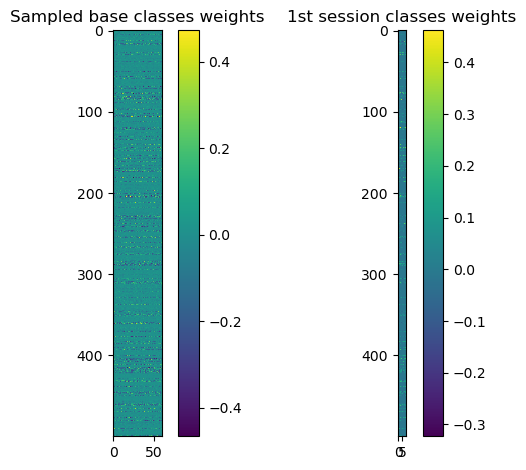

In [91]:
import numpy as np
import matplotlib.pyplot as plt

sample_hidden = np.random.randint(0, 1024, 500)
sample_out = np.random.randint(0, 100, 60)

def plot_heatmap(matrix, title):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.colorbar()


# Assuming you have two weight matrices, matrix1 and matrix2
# Replace these with your actual matrices
weight_matrix = eval_model.net.snn[-1].W.weight.detach().cpu().numpy()

print("BASE CLASSES:")
print("Range:", (np.min(weight_matrix[:100]), np.max(weight_matrix[:100])))
print("Mean:", np.mean(weight_matrix[:100]))
print("Std:", np.std(weight_matrix[:100]))
print("1st SESSION CLASSES:")
print("Range:", (np.min(weight_matrix[cur_class]), np.max(weight_matrix[cur_class])))
print("Mean:", np.mean(weight_matrix[cur_class]))
print("Std:", np.std(weight_matrix[cur_class]))

# Use np.ix_ to create an open mesh of indices
matrix1 = weight_matrix[np.ix_(sample_out, sample_hidden)].transpose()
# Replace cur_class with the appropriate value
matrix2 = weight_matrix[np.ix_(cur_class, sample_hidden)].transpose()


# Plot the first heatmap
plt.subplot(1, 2, 1)
plot_heatmap(matrix1, 'Sampled base classes weights')

# Plot the second heatmap
plt.subplot(1, 2, 2)
plot_heatmap(matrix2, '1st session classes weights')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [87]:
benchmark = Benchmark(eval_model, metric_list=[[],["classification_accuracy"]], dataloader=test_loader,
                                preprocessors=[to_device, encode, squeeze], postprocessors=[])

### Testing phase ###
eval_model.net.eval()

# Define session dataloaders for query and query + base_test samples
query_loader = DataLoader(query, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

full_session_test_set = ConcatDataset([base_test_set, query])
full_session_test_loader = DataLoader(full_session_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Create a mask function to only consider accuracy on classes presented so far
session_classes = torch.cat((torch.arange(0,100, dtype=int), torch.IntTensor(query_classes))) 
mask = torch.full((200,), float('inf')).to(device)
mask[session_classes] = 0
out_mask = lambda x: x - mask

# Run benchmark to evaluate accuracy of this specific session
session_results = benchmark.run(dataloader = full_session_test_loader, postprocessors=[out_mask, out2pred, torch.squeeze])
print(f"Session accuracy: {session_results['classification_accuracy']*100} %")

# Run benchmark on query classes only
query_results = benchmark.run(dataloader = query_loader, postprocessors=[out_mask, out2pred, torch.squeeze])
print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")

Running benchmark


100%|██████████| 43/43 [00:12<00:00,  3.41it/s]


Session accuracy: 1.8909090895544398 %
Running benchmark


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

Accuracy on new classes: 21.199999998509885 %


## ANN Weights 

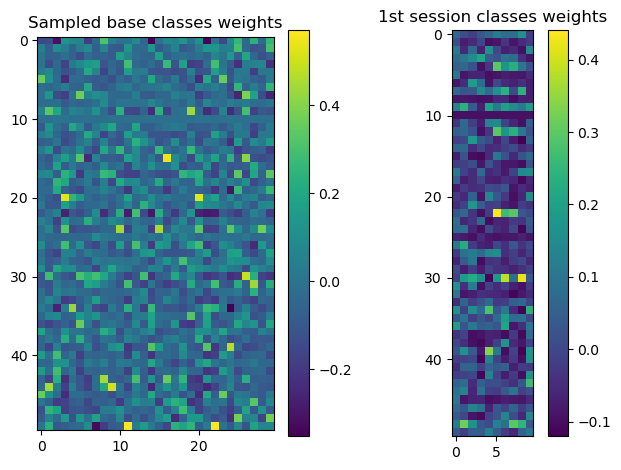

In [66]:
import numpy as np
import matplotlib.pyplot as plt

sample_hidden = np.random.randint(0, 513, 50)
sample_out = np.random.randint(0, 101, 30)

def plot_heatmap(matrix, title):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.colorbar()


# Assuming you have two weight matrices, matrix1 and matrix2
# Replace these with your actual matrices
weight_matrix = eval_model.net.output.weight.detach().cpu().numpy()

# Use np.ix_ to create an open mesh of indices
matrix1 = weight_matrix[np.ix_(sample_out, sample_hidden)].transpose()
# Replace cur_class with the appropriate value
matrix2 = weight_matrix[np.ix_(cur_class, sample_hidden)].transpose()


# Plot the first heatmap
plt.subplot(1, 2, 1)
plot_heatmap(matrix1, 'Sampled base classes weights')

# Plot the second heatmap
plt.subplot(1, 2, 2)
plot_heatmap(matrix2, '1st session classes weights')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()